In [7]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# Set dataset path
dataset_path = r"C:\Users\chris\Downloads\brain_tumor_dataset"

# Labels
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
image_size = 256

# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize between -1 and 1
])

# Custom PyTorch Dataset
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, labels, transform=None):
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform
        self.data = []
        
        for label in labels:
            folder = os.path.join(root_dir, label)
            for img_name in tqdm(os.listdir(folder)):
                img_path = os.path.join(folder, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    continue  # Skip corrupted images
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                self.data.append((img, label))
        
        # Encode labels numerically
        self.encoder = LabelEncoder()
        self.targets = self.encoder.fit_transform([label for _, label in self.data])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.encoder.transform([label])[0], dtype=torch.long)
        return img, label

# Load datasets
train_dataset = BrainTumorDataset(os.path.join(dataset_path, "Training"), labels, transform)
test_dataset = BrainTumorDataset(os.path.join(dataset_path, "Testing"), labels, transform)

# DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


100%|██████████| 74/74 [00:00<00:00, 100.08it/s]

Training samples: 2870, Testing samples: 394


In [6]:
import os

dataset_path = r"C:\Users\chris\Downloads\brain_tumor_dataset"

print("Folders inside dataset path:", os.listdir(dataset_path))
print("Folders inside train:", os.listdir(os.path.join(dataset_path, "Training")))
print("Folders inside test:", os.listdir(os.path.join(dataset_path, "Testing")))


Folders inside dataset path: ['Testing', 'Training']
Folders inside train: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Folders inside test: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].


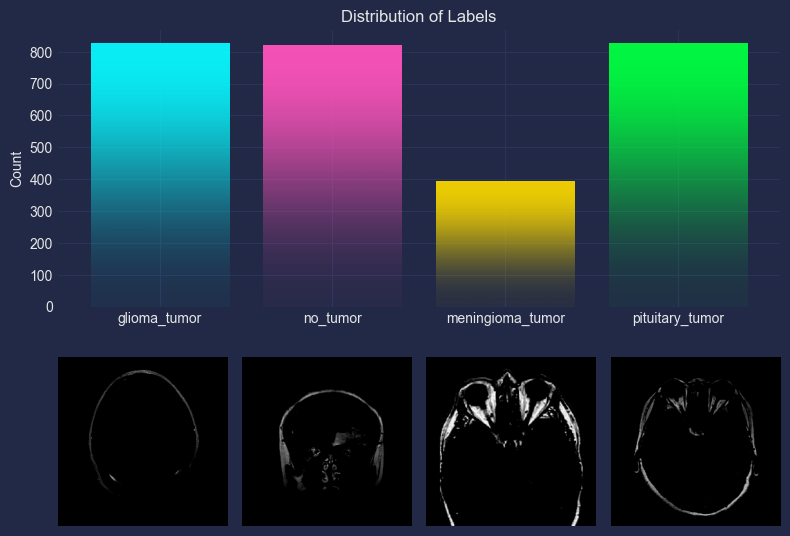

In [8]:
import matplotlib.pyplot as plt
import mplcyberpunk
import torch

# Convert labels to tensor for counting occurrences
y_train_tensor = torch.tensor(train_dataset.targets)

# Calculate label counts
label_counts = {label: torch.sum(y_train_tensor == idx).item() for idx, label in enumerate(labels)}

# Create figure
plt.figure(figsize=(8, 6))
colors = ["C0", "C1", "C2", "C3"]

# Bar plot (label distribution)
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images
k = 0
for i, label in enumerate(labels):
    for img, lbl in train_dataset:  # Iterate over dataset to find a sample
        if lbl.item() == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
            plt.axis('off')
            k += 1
            break

plt.tight_layout()
plt.show()


In [10]:
import torchvision.transforms as transforms

# Define augmentation transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(20),  # Rotate up to ±20 degrees
    transforms.RandomResizedCrop(image_size, scale=(0.9, 1.0)),  # Zoom within 90-100% range
    transforms.RandomHorizontalFlip(p=0.0),  # No horizontal flip
    transforms.RandomVerticalFlip(p=0.0),  # No vertical flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize between -1 and 1
])

# Apply only basic transformations to test set (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Reload datasets with transformations
train_dataset = BrainTumorDataset(os.path.join(dataset_path, "Training"), labels, transform=train_transform)
test_dataset = BrainTumorDataset(os.path.join(dataset_path, "Testing"), labels, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Augmentation applied to training dataset!")


100%|██████████| 74/74 [00:00<00:00, 347.42it/s]


Augmentation applied to training dataset!


In [11]:
import matplotlib.pyplot as plt
import random
import torch

def visualize_augmented_images(dataset, transform, num_samples=3, num_augmented_images=3):
    augmented_images = []
    
    # Select random samples from dataset
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        original_img, _ = dataset[idx]  # Get original image (before augmentation)
        
        # Apply augmentation multiple times to visualize different variations
        augmented_samples = [original_img]  # First image is the original
        for _ in range(num_augmented_images):
            augmented_img = transform(original_img)  # Apply augmentation
            augmented_samples.append(augmented_img)
        
        augmented_images.append(augmented_samples)

    # Plot original and augmented images
    fig, axes = plt.subplots(num_samples, num_augmented_images + 1, figsize=(12, num_samples * 3))
    
    for i, sample in enumerate(augmented_images):
        for j, img in enumerate(sample):
            axes[i, j].imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
            axes[i, j].axis('off')
            axes[i, j].set_title("Original Image" if j == 0 else f"Augmented {j}")

    plt.tight_layout()
    plt.show()

# Visualize augmented images
visualize_augmented_images(train_dataset, train_transform, num_samples=3, num_augmented_images=3)


TypeError: Unexpected type <class 'numpy.ndarray'>

In [12]:
from PIL import Image

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, labels, transform=None):
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform
        self.data = []
        
        for label in labels:
            label_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                self.data.append((img_path, label))

        self.encoder = LabelEncoder()
        self.encoder.fit(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        
        # ✅ Read image as NumPy array
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = Image.fromarray(img)  # ✅ Convert NumPy array to PIL Image

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.encoder.transform([label])[0], dtype=torch.long)
        return img, label


In [14]:
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms

# Define dataset transformations (including normalization)
train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(image_size, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.0),
    transforms.RandomVerticalFlip(p=0.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1,1]
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
full_train_dataset = BrainTumorDataset(os.path.join(dataset_path, "Training"), labels, transform=train_transform)
test_dataset = BrainTumorDataset(os.path.join(dataset_path, "Testing"), labels, transform=test_transform)

# Split train dataset into training (81%) & validation (9%)
train_size = int(0.81 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size

train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(valid_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')


Train dataset size: 2324
Validation dataset size: 546
Test dataset size: 394


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),  # Adjust based on input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)  # No Softmax (handled by CrossEntropyLoss)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorCNN(num_classes=4).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Print model summary
print(model)


BrainTumorCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, inplace=False)
    (16): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
  

In [16]:
import time
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training hyperparameters
num_epochs = 50
batch_size = 64

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Training loop
history = {"train_loss": [], "valid_loss": [], "train_acc": [], "valid_acc": []}
start_time = time.time()

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss, correct_train, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    valid_loss, correct_valid, total_valid = 0, 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_valid += (predicted == labels).sum().item()
            total_valid += labels.size(0)

    valid_accuracy = correct_valid / total_valid
    valid_loss /= len(valid_loader)

    # Store loss and accuracy
    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["train_acc"].append(train_accuracy)
    history["valid_acc"].append(valid_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}")

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

# Save the trained model
torch.save(model.state_dict(), "brain_tumor_model.pth")
print("Model saved as brain_tumor_model.pth")


Epoch 1/50 | Train Loss: 1.3574, Train Acc: 0.2870 | Valid Loss: 1.3434, Valid Acc: 0.2985
Epoch 2/50 | Train Loss: 1.2712, Train Acc: 0.3924 | Valid Loss: 1.1741, Valid Acc: 0.4707
Epoch 3/50 | Train Loss: 1.0499, Train Acc: 0.5676 | Valid Loss: 0.9382, Valid Acc: 0.6612
Epoch 4/50 | Train Loss: 0.9267, Train Acc: 0.6110 | Valid Loss: 0.9116, Valid Acc: 0.6484
Epoch 5/50 | Train Loss: 0.8804, Train Acc: 0.6218 | Valid Loss: 1.0576, Valid Acc: 0.5256
Epoch 6/50 | Train Loss: 0.8207, Train Acc: 0.6493 | Valid Loss: 0.7383, Valid Acc: 0.7179
Epoch 7/50 | Train Loss: 0.7899, Train Acc: 0.6670 | Valid Loss: 0.7369, Valid Acc: 0.6996
Epoch 8/50 | Train Loss: 0.7257, Train Acc: 0.6790 | Valid Loss: 0.6491, Valid Acc: 0.7308
Epoch 9/50 | Train Loss: 0.7068, Train Acc: 0.6975 | Valid Loss: 0.6383, Valid Acc: 0.7399
Epoch 10/50 | Train Loss: 0.6898, Train Acc: 0.7009 | Valid Loss: 0.6348, Valid Acc: 0.7582
Epoch 11/50 | Train Loss: 0.6458, Train Acc: 0.7250 | Valid Loss: 0.6272, Valid Acc: 0.73

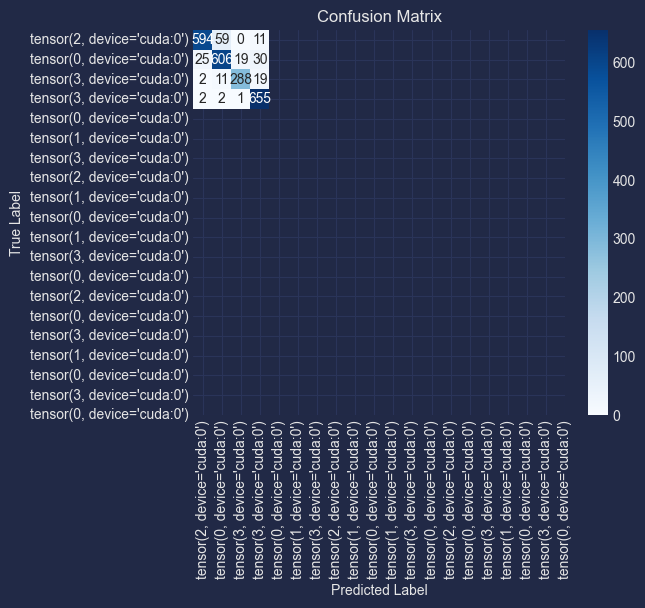

In [17]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Set model to evaluation mode
model.eval()

# Collect true labels and predictions
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in train_loader:  # Using training set
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())  # Convert tensors to NumPy
        y_pred.extend(predictions.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


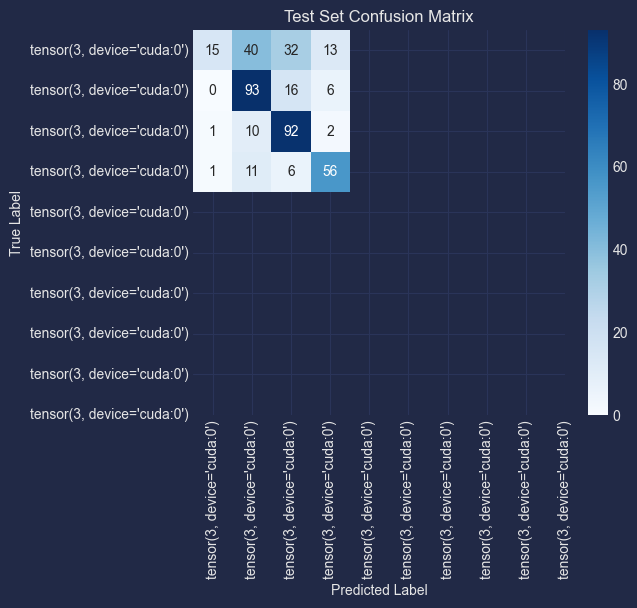

In [19]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Set model to evaluation mode
model.eval()

# Collect true labels and predictions
y_true_test, y_pred_test = [], []

with torch.no_grad():
    for images, labels in test_loader:  # Using test set
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

        y_true_test.extend(labels.cpu().numpy())  # Convert tensors to NumPy
        y_pred_test.extend(predictions.cpu().numpy())

# Compute confusion matrix
conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [21]:
print(classification_report(y_true_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.88      0.15      0.26       100
           1       0.60      0.81      0.69       115
           2       0.63      0.88      0.73       105
           3       0.73      0.76      0.74        74

    accuracy                           0.65       394
   macro avg       0.71      0.65      0.61       394
weighted avg       0.70      0.65      0.60       394



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].


Predicted label: 3 
Actual label: 3 
Confidence: 53.32%



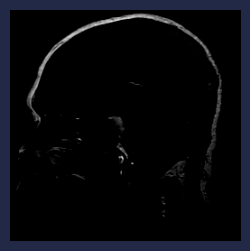

In [22]:
import torch
import random
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Select a random index from the test set
random_index = random.randint(0, len(test_dataset) - 1)

# Load the random image and its actual label
random_img, actual_label = test_dataset[random_index]

# Move image to the same device as the model
random_img = random_img.to(device).unsqueeze(0)  # Add batch dimension

# Get predictions
with torch.no_grad():
    predictions = model(random_img)
    predicted_class = torch.argmax(predictions, dim=1).item()
    confidence = torch.softmax(predictions, dim=1)[0][predicted_class].item() * 100  # Convert to percentage

# Convert label index to class name
predicted_label = labels[predicted_class]
actual_label_name = labels[actual_label]  # Assuming test_dataset provides labels as indices

# Display prediction results
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label_name}\033[0m \n\033[93mConfidence: {confidence:.2f}%\033[0m\n")

# Display the image
plt.figure(figsize=(3, 3))
plt.imshow(random_img.cpu().squeeze().permute(1, 2, 0))  # Convert PyTorch tensor to image format
plt.axis('off')
plt.show()


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN model
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(0.15)
        self.dropout2 = nn.Dropout(0.45)

        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust based on final feature map size
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)

        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)

        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout1(x)

        x = torch.flatten(x, start_dim=1)  # Flatten before FC layer
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)


BrainTumorCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.15, inplace=False)
  (dropout2): Dropout(p=0.45, inplace=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [25]:
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    total_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():  # Disable gradient calculations for validation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(dataloader), 100 * correct / total  # Return avg loss & accuracy


import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define training parameters
num_epochs = 35
batch_size = 64

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Training loop
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    val_loss, val_acc = evaluate_model(model, valid_loader, criterion)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

end_time = time.time()
runtime = end_time - start_time

print(f"Total runtime: {runtime:.2f} seconds")


Epoch [1/35], Train Loss: 0.9710, Train Acc: 59.77%, Val Loss: 0.8227, Val Acc: 67.77%
Epoch [2/35], Train Loss: 0.8601, Train Acc: 62.48%, Val Loss: 0.7778, Val Acc: 69.23%
Epoch [3/35], Train Loss: 0.7903, Train Acc: 66.95%, Val Loss: 0.7195, Val Acc: 71.79%
Epoch [4/35], Train Loss: 0.7526, Train Acc: 68.33%, Val Loss: 0.7032, Val Acc: 71.25%
Epoch [5/35], Train Loss: 0.7003, Train Acc: 71.30%, Val Loss: 0.6665, Val Acc: 71.06%
Epoch [6/35], Train Loss: 0.6847, Train Acc: 71.21%, Val Loss: 0.6842, Val Acc: 73.44%
Epoch [7/35], Train Loss: 0.6540, Train Acc: 72.42%, Val Loss: 0.6621, Val Acc: 75.27%
Epoch [8/35], Train Loss: 0.6549, Train Acc: 72.25%, Val Loss: 0.6154, Val Acc: 75.46%
Epoch [9/35], Train Loss: 0.6459, Train Acc: 74.18%, Val Loss: 0.6409, Val Acc: 75.46%
Epoch [10/35], Train Loss: 0.5940, Train Acc: 75.60%, Val Loss: 0.5746, Val Acc: 76.92%
Epoch [11/35], Train Loss: 0.5657, Train Acc: 77.19%, Val Loss: 0.5278, Val Acc: 76.37%
Epoch [12/35], Train Loss: 0.5493, Train 

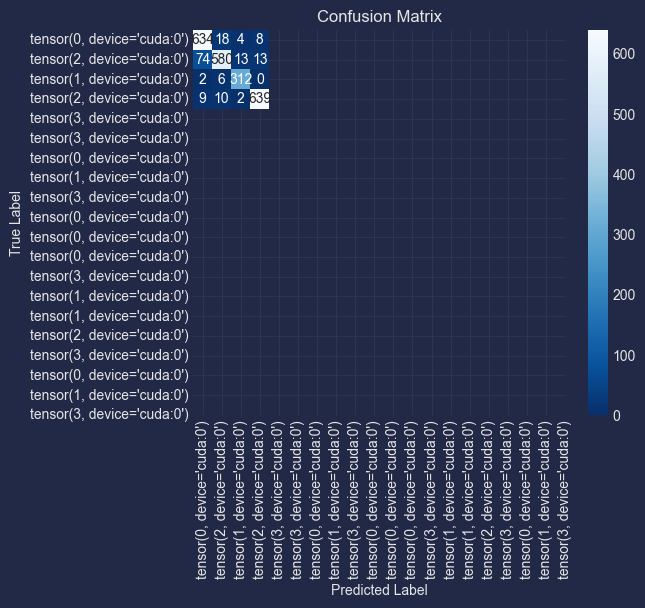

In [26]:
import torch

# Ensure model is in evaluation mode
model.eval()

# Get predictions
y_true = []
y_pred = []

with torch.no_grad():  # Disable gradients for evaluation
    for images, labels in train_loader:  # Assuming `train_loader` is your DataLoader
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        
        y_true.extend(labels.cpu().numpy())  # Convert to NumPy for sklearn
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r',
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


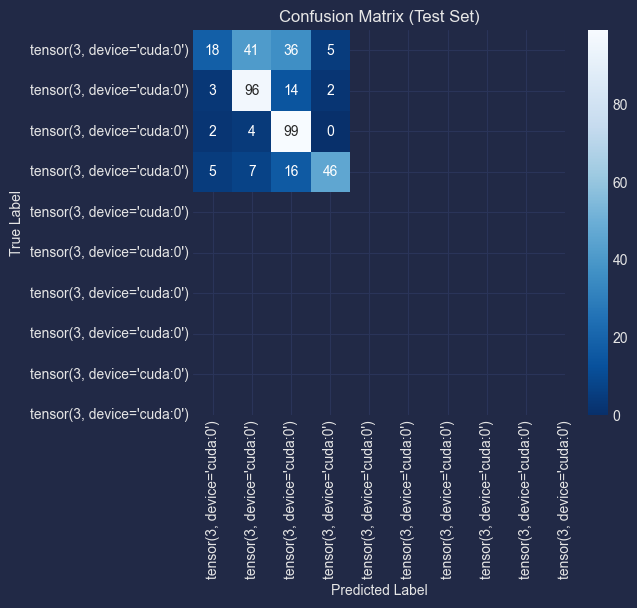

In [27]:
# Ensure model is in evaluation mode
model.eval()

# Get predictions for the test set
y_true_test = []
y_pred_test = []

with torch.no_grad():  # Disable gradients for evaluation
    for images, labels in test_loader:  # Assuming `test_loader` is your DataLoader for X_test
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        
        y_true_test.extend(labels.cpu().numpy())  # Convert to NumPy
        y_pred_test.extend(predicted.cpu().numpy())

# Generate confusion matrix
conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues_r',
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [28]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.64      0.18      0.28       100
           1       0.65      0.83      0.73       115
           2       0.60      0.94      0.73       105
           3       0.87      0.62      0.72        74

    accuracy                           0.66       394
   macro avg       0.69      0.64      0.62       394
weighted avg       0.68      0.66      0.62       394



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.92941177].


Predicted label: 3 
Actual label: 3 
Confidence: 70.00%

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
[1.4818092e-05 6.9999290e+01 2.9973248e+01 2.7448907e-02]


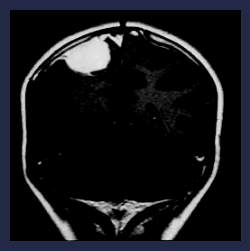

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Select a random test image
random_index = np.random.randint(0, len(test_dataset))  # Assuming test_dataset is your dataset object
random_img, actual_label = test_dataset[random_index]  # Get image and actual label

# Add batch dimension and move to device
random_img_tensor = random_img.unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    predictions = model(random_img_tensor)
    predicted_class = torch.argmax(predictions, dim=1).item()  # Get predicted class index

# Convert class indices to labels
predicted_label = labels[predicted_class]
actual_label_str = labels[actual_label]

# Get confidence score
confidence = torch.softmax(predictions, dim=1)[0][predicted_class].item() * 100

# Display results
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label_str}\033[0m \n\033[93mConfidence: {confidence:.2f}%\033[0m\n")
print(labels)
print(torch.softmax(predictions, dim=1)[0].cpu().numpy() * 100)

# Plot the image
plt.figure(figsize=(3,3))
plt.imshow(random_img.permute(1, 2, 0))  # Convert tensor format (C, H, W) -> (H, W, C)
plt.axis('off')
plt.show()


c:\my_new_environment\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:05<00:00, 194.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


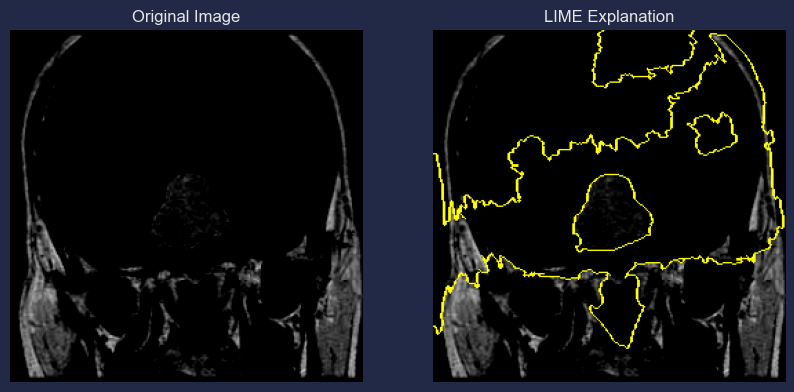

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Function to preprocess the image for LIME
def batch_predict(images):
    images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2).to(device)  # Convert to tensor and move to device
    with torch.no_grad():
        preds = model(images)  # Get model predictions
    return preds.cpu().numpy()  # Convert back to NumPy

# Select a random test image
random_index = np.random.randint(0, len(test_dataset))
random_img, actual_label = test_dataset[random_index]  # Get image and actual label

# Convert image tensor to NumPy format
image_3d = random_img.permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)

# Initialize the LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation using LIME
explanation = explainer.explain_instance(
    image_3d.astype('double'),  # Convert image to proper format
    batch_predict,  # Model prediction function
    top_labels=5,  # Number of top labels to explain
    hide_color=0,  # Color for "turned off" superpixels
    num_samples=1000  # Number of perturbed samples
)

# Get the explanation mask for the top predicted class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

# Display the original image and LIME explanation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image_3d)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(mark_boundaries(temp, mask))
ax[1].set_title("LIME Explanation")
ax[1].axis('off')

plt.show()


In [33]:
import torch
import numpy as np
from lime import lime_image

# Select a random test image
random_index = torch.randint(0, len(X_test), (1,)).item()
random_img = X_test[random_index]  # Shape: (H, W, C) -> (256, 256, 3)

# Convert to PyTorch tensor and normalize
preprocessed_img = torch.tensor(random_img, dtype=torch.float32).permute(2, 0, 1) / 255.0  # (3, 256, 256)

# Add batch dimension
preprocessed_img = preprocessed_img.unsqueeze(0)  # Shape: (1, 3, 256, 256)

# Convert image tensor to NumPy for LIME
image_3d = preprocessed_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # (256, 256, 3)


import torch
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image

# Ensure the image tensor is on CPU and convert it to NumPy
image_3d = preprocessed_img.squeeze(0).cpu().numpy()  # Remove batch dimension

# Initialize the LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation for the image using LIME
explanation = explainer.explain_instance(
    image_3d.astype('double'),  # Ensure the image is in the correct 3D format
    lambda x: model(torch.tensor(x).permute(0, 3, 1, 2).float()).detach().numpy(),  # Convert to PyTorch format
    top_labels=5,
    hide_color=1,
    num_samples=1000
)

# Get the image and mask from the LIME explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=1,
    hide_rest=False
)

# Display the original image with the mask boundaries
plt.figure(figsize=(5, 5))
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()



NameError: name 'X_test' is not defined

In [37]:
import torch
import numpy as np
from lime import lime_image

# Get a batch of test images from the DataLoader
data_iter = iter(test_loader)
images, labels = next(data_iter)  # Get a batch

# Select a random image from the batch
random_index = torch.randint(0, images.shape[0], (1,)).item()
random_img = images[random_index]  # Shape: (C, H, W)

# Convert PyTorch tensor to NumPy (CHW -> HWC)
image_3d = random_img.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) → (H, W, C)

# Normalize image to range [0, 255] (if originally in [0,1])
image_3d = (image_3d * 255).astype(np.uint8)  # Ensure dtype is uint8

# Now image_3d is correctly formatted for LIME
import torch
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image

# Ensure the image tensor is on CPU and convert it to NumPy
image_3d = preprocessed_img.squeeze(0).cpu().numpy()  # Remove batch dimension

# Initialize the LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation for the image using LIME
explanation = explainer.explain_instance(
    image_3d.astype('double'),  # Ensure the image is in the correct 3D format
    lambda x: model(torch.tensor(x).permute(0, 3, 1, 2).float()).detach().numpy(),  # Convert to PyTorch format
    top_labels=5,
    hide_color=1,
    num_samples=1000
)

# Get the image and mask from the LIME explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=1,
    hide_rest=False
)

# Display the original image with the mask boundaries
plt.figure(figsize=(5, 5))
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()


ValueError: Only RGB images can be converted to Lab space.

100%|██████████| 1000/1000 [00:07<00:00, 125.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


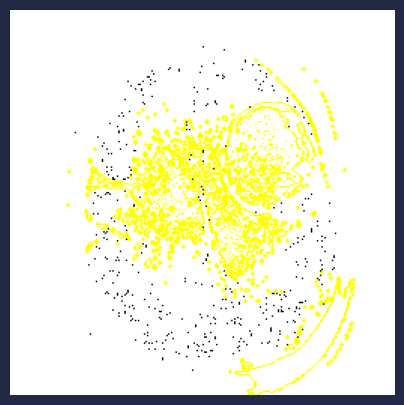

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image

# Ensure the image tensor is on CPU and convert it to NumPy
image_3d = preprocessed_img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) → (H, W, C)

# Normalize image if needed (LIME requires values in [0, 255])
image_3d = (image_3d * 255).astype(np.uint8)

# Initialize the LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Define a function to predict using the PyTorch model
def model_predict(images):
    images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)  # Convert to PyTorch (N, C, H, W)
    with torch.no_grad():
        outputs = model(images).cpu().numpy()  # Get model predictions
    return outputs

# Generate explanation for the image using LIME
explanation = explainer.explain_instance(
    image_3d.astype('double'),  # Ensure the image is in the correct 3D format
    model_predict,  # Use the PyTorch model
    top_labels=5,
    hide_color=1,
    num_samples=1000
)

# Get the image and mask from the LIME explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  
    positive_only=True,
    num_features=5,  # Increase number of features for better visualization
    hide_rest=False
)

# Display the original image with the mask boundaries
plt.figure(figsize=(5, 5))
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


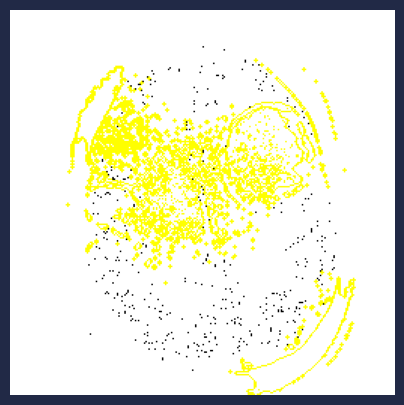

In [39]:
# Get the image and mask from the LIME explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # The top label
    positive_only=False,        # Show both positive and negative features
    num_features=5,             # Number of superpixels to highlight
    hide_rest=False             # Display the entire image
)

# Display the original image with highlighted superpixels
plt.figure(figsize=(5, 5))
plt.imshow(mark_boundaries(temp, mask))  # No need to multiply by 255
plt.axis('off')  # Hide the axis for cleaner visualization
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


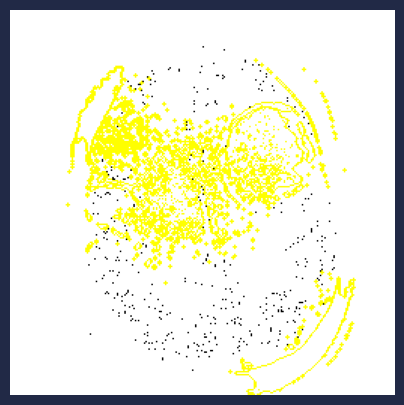

In [40]:
# Get the image and mask from the LIME explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # The top label
    positive_only=False,        # Show both positive and negative features
    num_features=5,             # Number of superpixels to highlight
    hide_rest=False             # Display the entire image
)

# Display the original image with highlighted superpixels
plt.figure(figsize=(5, 5))
plt.imshow(mark_boundaries(temp, mask))  # No need to multiply by 255
plt.axis('off')  # Hide the axis for cleaner visualization
plt.show()


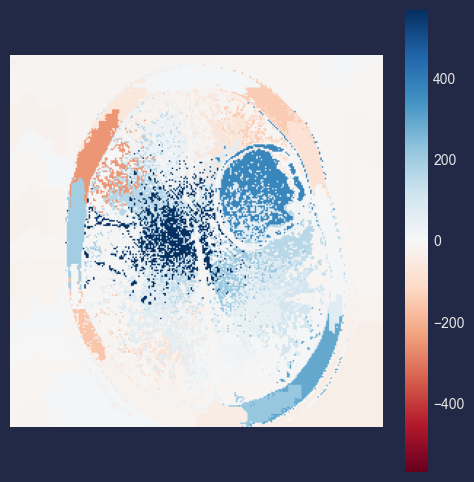

In [41]:
# Select the same class explained on the figures above
ind = explanation.top_labels[0]

# Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(lambda x: dict_heatmap.get(x, 0))(explanation.segments)  # Ensure default value for missing segments

# Plot heatmap with symmetrical colorbar
plt.figure(figsize=(6, 6))
plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.colorbar()
plt.axis('off')  # Hide the axis for better visualization
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


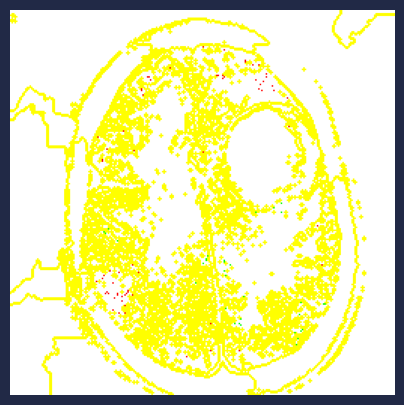

In [42]:
# Get the image and mask from the LIME explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  
    positive_only=False,        
    num_features=1000,          # Highlight more superpixels
    hide_rest=False,           
    min_weight=0.05             # Ignore weakly contributing areas
)

# Display the original image with the mask boundaries
plt.figure(figsize=(5, 5))
plt.imshow(mark_boundaries(temp, mask))  # Ensure no unintended normalization issues
plt.axis('off')  # Hide the axis for cleaner visualization
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


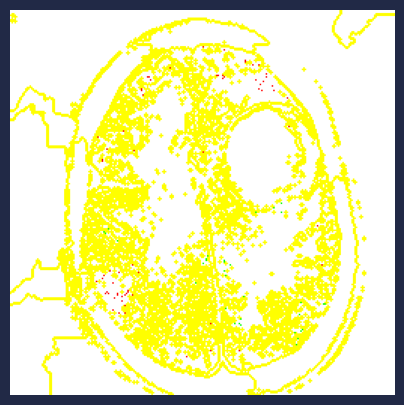

In [43]:
# Get the image and mask from the LIME explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  
    positive_only=False,        
    num_features=1000,          # Highlight more superpixels
    hide_rest=False,           
    min_weight=0.05             # Ignore weakly contributing areas
)

# Display the original image with the mask boundaries
plt.figure(figsize=(5, 5))
plt.imshow(mark_boundaries(temp, mask))  # Ensure no unintended normalization issues
plt.axis('off')  # Hide the axis for cleaner visualization
plt.show()


In [45]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the trained model
model_path = "brain_tumor_model.pth"  # Change this to your actual model path
model = torch.load(model_path, map_location=torch.device('cpu'))  # Load on CPU
model.eval()  # Set model to evaluation mode


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [46]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the trained model
model_path = "brain_tumor_model.pth"  # Change this to your actual model path
model = torch.load(model_path, map_location=torch.device('cpu'))  # Load on CPU
model.eval()  # Set model to evaluation mode


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [47]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from model_architecture import BrainTumorCNN  # Import your model class

# Define the same model architecture before loading state_dict
model = BrainTumorCNN()  # Initialize the model
model.load_state_dict(torch.load("brain_tumor_model.pth", map_location=torch.device('cpu')))  # Load weights
model.eval()  # Set model to evaluation mode


ModuleNotFoundError: No module named 'model_architecture'

In [49]:
torch.save(model.state_dict(), "brain_tumor_model_weights.pth")

import json

labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]  # Adjust based on your dataset
with open("class_labels.json", "w") as f:
    json.dump(labels, f)

import shutil
shutil.copy("path_to_sample_image.jpg", "example_image.jpg")




AttributeError: 'collections.OrderedDict' object has no attribute 'state_dict'

In [50]:
import torch
import json
import streamlit as st
from PIL import Image
import torchvision.transforms as transforms
from model_architecture import BrainTumorCNN  # Ensure this matches your actual model

# Load class labels
with open("class_labels.json", "r") as f:
    class_labels = json.load(f)

# Load the trained model
model = BrainTumorCNN()  # Ensure this matches your actual model
model.load_state_dict(torch.load("brain_tumor_model_weights.pth", map_location=torch.device('cpu')))
model.eval()

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Streamlit UI
st.title("Brain Tumor Classification with XAI")

uploaded_file = st.file_uploader("Upload a brain MRI image", type=["jpg", "png"])

if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    input_tensor = transform(image).unsqueeze(0)

    # Model prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    st.write(f"### Prediction: {class_labels[predicted_class]}")

    # (You can integrate LIME here for explainability)


ModuleNotFoundError: No module named 'model_architecture'

after saving parameters

In [54]:
import torch

torch.save(model, "brain_tumor_model.pth")


In [56]:
import torch

model_path = "brain_tumor_model.pth"  # Or "brain_tumor_weights.pth"
model = torch.load(model_path, map_location=torch.device('cpu'))

print(type(model))  # Check if it's an OrderedDict


<class 'collections.OrderedDict'>


In [58]:
torch.save(model, "brain_tumor_model.pth")


In [59]:
model = torch.load("brain_tumor_model.pth", map_location=torch.device('cpu'))
model.eval()


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the trained model
model_path = "brain_tumor_model.pth"  # Change this to your actual model path
model = torch.load(model_path, map_location=torch.device('cpu'))  # Load on CPU
model.eval()  # Set model to evaluation mode


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [57]:
torch.save(model.state_dict(), "brain_tumor_weights.pth")


AttributeError: 'collections.OrderedDict' object has no attribute 'state_dict'

In [53]:
import json

labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
with open("class_labels.json", "w") as f:
    json.dump(labels, f)


In [51]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

def get_lime_explanation(model, image_tensor):
    explainer = lime_image.LimeImageExplainer()
    
    # Convert tensor to NumPy array
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    # Define prediction function
    def predict_fn(images):
        images_tensor = torch.tensor(images).permute(0, 3, 1, 2).float()
        with torch.no_grad():
            outputs = model(images_tensor)
        return outputs.numpy()
    
    # Generate explanation
    explanation = explainer.explain_instance(image_np.astype('double'), 
                                             predict_fn, 
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000)
    
    # Get image mask
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], 
        positive_only=False, 
        num_features=5, 
        hide_rest=False
    )
    
    return temp, mask


In [52]:
import torch
import json
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from model import BrainTumorCNN
from utils import preprocess_image, get_lime_explanation
from PIL import Image

# Load class labels
with open("class_labels.json", "r") as f:
    class_labels = json.load(f)

# Load the trained model
model = BrainTumorCNN()
model.load_state_dict(torch.load("brain_tumor_weights.pth", map_location=torch.device('cpu')))
model.eval()

st.title("🧠 Brain Tumor Classification with Explainable AI (XAI)")

uploaded_file = st.file_uploader("Upload a brain MRI image", type=["jpg", "png"])

if uploaded_file:
    # Preprocess the image
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    input_tensor = preprocess_image(uploaded_file)

    # Model prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    st.write(f"### 🎯 Prediction: **{class_labels[predicted_class]}**")

    # Generate LIME Explanation
    temp, mask = get_lime_explanation(model, input_tensor)

    # Display Explanation
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(mark_boundaries(temp, mask))
    ax.axis("off")
    st.pyplot(fig)


ModuleNotFoundError: No module named 'model'